In [1]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
raw_data_path = constants.PATH_TO_CORTEX_all_params_raw
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS_WITH_SLOPES

In [3]:
subjects_raw_data = DataProcessor(raw_data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
analyzed_data = StatisticsWrapper.calc_mean_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

In [99]:
def extract_outliers(data, param):
     outliers = {}
     threshold = 3

     for roi_value, roi_name in chosen_rois_dict.items():
          roi_to_check_data = data[data.ROI == roi_value]
          Q1 = roi_to_check_data[param].quantile(0.25)
          Q3 = roi_to_check_data[param].quantile(0.75)
          IQR = Q3 - Q1


          outliers_df = roi_to_check_data[(roi_to_check_data[param] < Q1 - threshold * IQR) | (roi_to_check_data[param] > Q3 + threshold * IQR)]

          if outliers_df.subjects.values.size > 0:
               outliers[roi_value] = outliers_df.subjects.tolist()

     return outliers

In [71]:
outliers_counter = {}

for param in params_to_work_with:
    subjects_outliers_counter = {}
    outliers = extract_outliers(chosen_data, param)

    for roi, roi_outliers in outliers.items():
            for outlier in roi_outliers:
                if outlier in subjects_outliers_counter:
                    subjects_outliers_counter[outlier] += 1
                    outliers_counter[outlier] += 1
                else:
                    subjects_outliers_counter[outlier]  = 1
                    if outlier not in outliers_counter:
                        outliers_counter[outlier] = 1

    subjects_outliers_counter = dict(sorted(subjects_outliers_counter.items(), key=lambda item: item[1], reverse=True))
    # print(f'{param} outliers: {outliers}')
    # print(f'{param} outliers counter: {subjects_outliers_counter}')
    # print(f'{param} outliers counter: {outliers_counter}')
    # print('----------------------------------------------------------')

outliers_counter = dict(sorted(outliers_counter.items(), key=lambda item: item[1], reverse=True))
print(f'outliers counter: {outliers_counter}')

outliers counter: {'H036_EV': 16, 'H054_AE': 14, 'H047_DC': 12, 'H037_YB': 9, 'H018_AS': 7, 'H045_PO': 6, 'H051_YK': 5, 'H050_AB': 5, 'H046_NB': 5, 'H025_SH': 5, 'H033_MB': 4, 'H061_SE': 4, 'H019_AF': 3, 'H048_GA': 3, 'H055_MY': 3, 'H039_JH': 3, 'H044_AZ': 3, 'H052_OF': 3, 'H042_MS': 3, 'H022_YR': 3, 'H023_IN': 2, 'H038_GB': 2, 'H020_RR': 2, 'H040_RK': 2, 'H031_IN': 2, 'H035_DN': 2, 'H032_JD': 2, 'H027_SB': 2, 'H021_DH': 1, 'H041_VG': 1, 'H030_NS': 1, 'H043_OS': 1, 'H028_LC': 1, 'H049_SV': 1, 'H026_LY': 1, 'H034_HB': 1}


In [57]:
data_path = os.path.join(constants.ANALYSIS_DIR, 'H054_AE')
seg_path = os.path.join(data_path, os.listdir(data_path)[0], constants.BASIC_SEG)
brain_path = os.path.join(data_path, os.listdir(data_path)[0], constants.MAP_R1)

In [58]:
os.system(f'freeview -v {brain_path} {seg_path}:colormap=lut &')

0

In [100]:
# remove outliers
# chosen_data[chosen_data.subjects == 'H036_EV'].Age.iloc[0]

chosen_data = chosen_data[~chosen_data.subjects.isin(['H036_EV', 'H054_AE', 'H047_DC', 'H037_YB'])]
chosen_data.subjects.nunique()

32

In [4]:
group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

In [117]:
def calculate_cv_for_subjects(data_groups, group_by_param, params, x_axis, use_reg=False, fig_size=(20, 8), connect_scatter=False):
    for param in params:
        if 'Slope' in param:
            continue
        plt.figure(figsize=fig_size)

        for data, color, label in data_groups:
            # Calculate CV params
            means = data.groupby(group_by_param)[[param, x_axis]].mean()
            stds = data.groupby(group_by_param)[param].std()
            cv = (stds / means[param])

            if use_reg:
                model = LinearRegression()
                model.fit(np.array(means[x_axis]).reshape(-1, 1), np.array(cv).reshape(-1, 1))
                # Get the slope and intercept
                slope = model.coef_[0]
                intercept = model.intercept_
                x_fit = np.linspace(min(means[x_axis]), max(means[x_axis]), 20)  # 100 points for smoother line
                x_axis_to_use = means[x_axis]
            else:
                x_axis_to_use = [str(int(i)) for i in means[x_axis]]

            cv_data = pd.DataFrame({
                'CV': cv,
                x_axis: x_axis_to_use
            })

            # Create the plot
            plt.scatter(cv_data[x_axis], cv_data['CV'], color=color, label=label, s=50, alpha=0.7)
            if connect_scatter:
                plt.plot(cv_data[x_axis], cv_data['CV'])
            if use_reg:
                plt.plot(x_fit, slope * x_fit + intercept, color='red')
            plt.xlabel(x_axis)
            plt.ylabel('CV')

        plt.title(f'{param}')
        plt.grid(True)
        plt.legend()

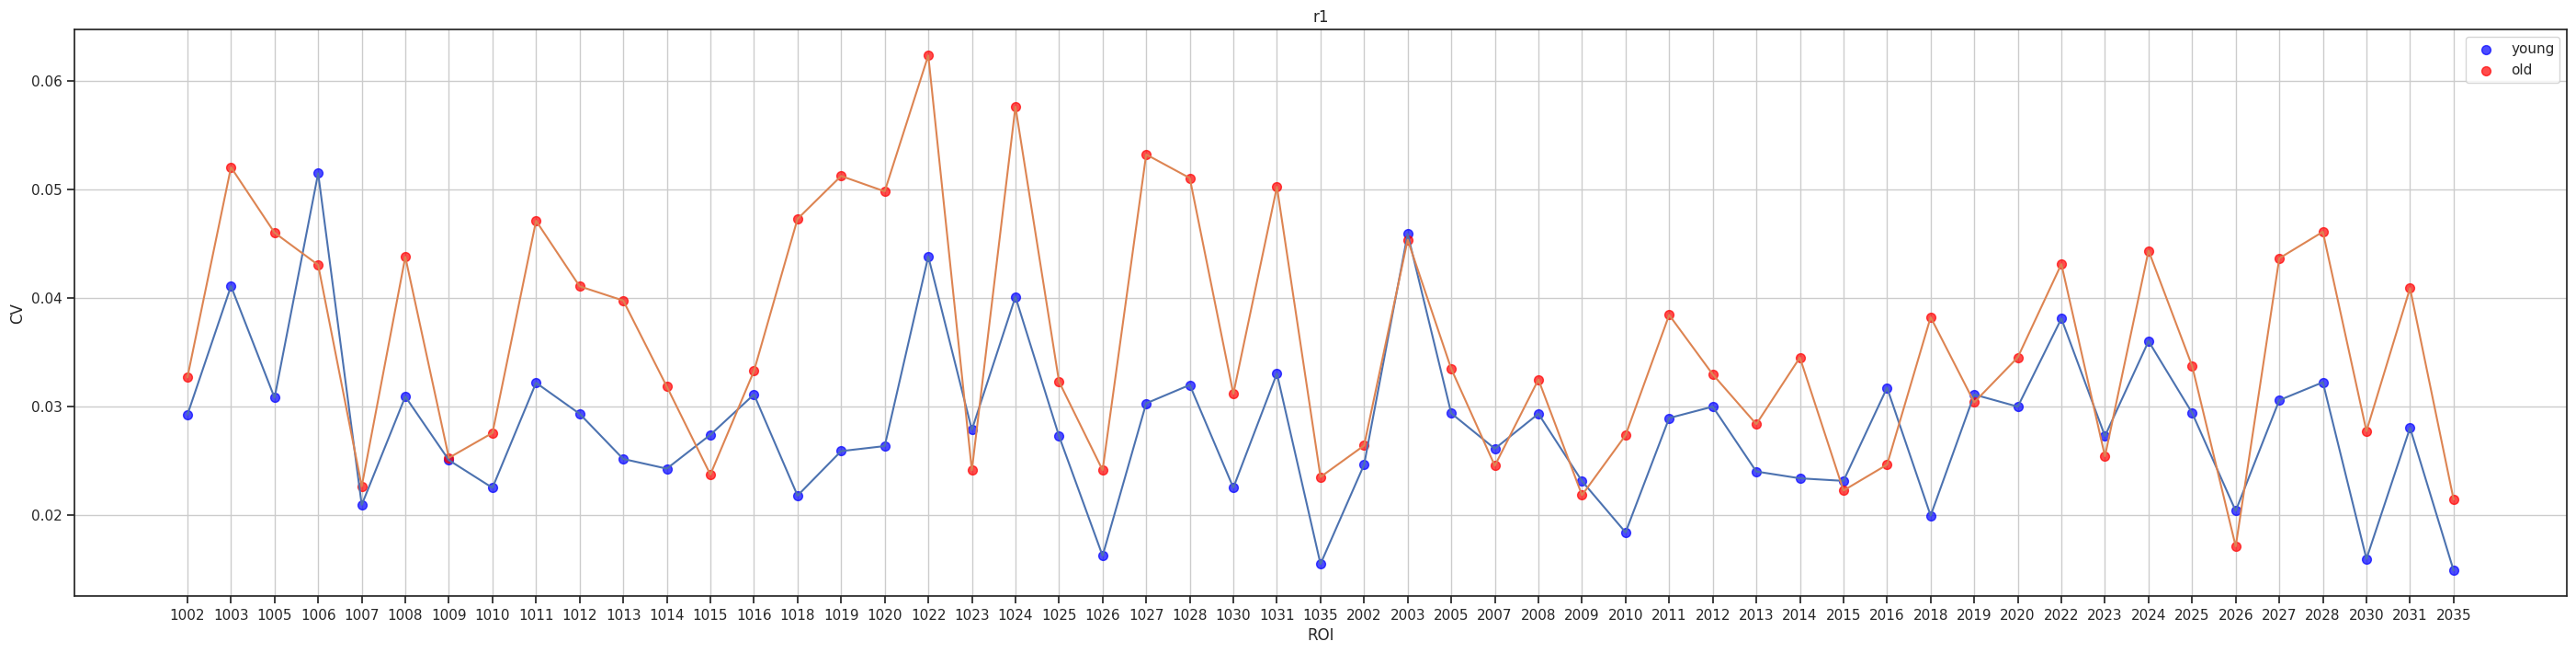

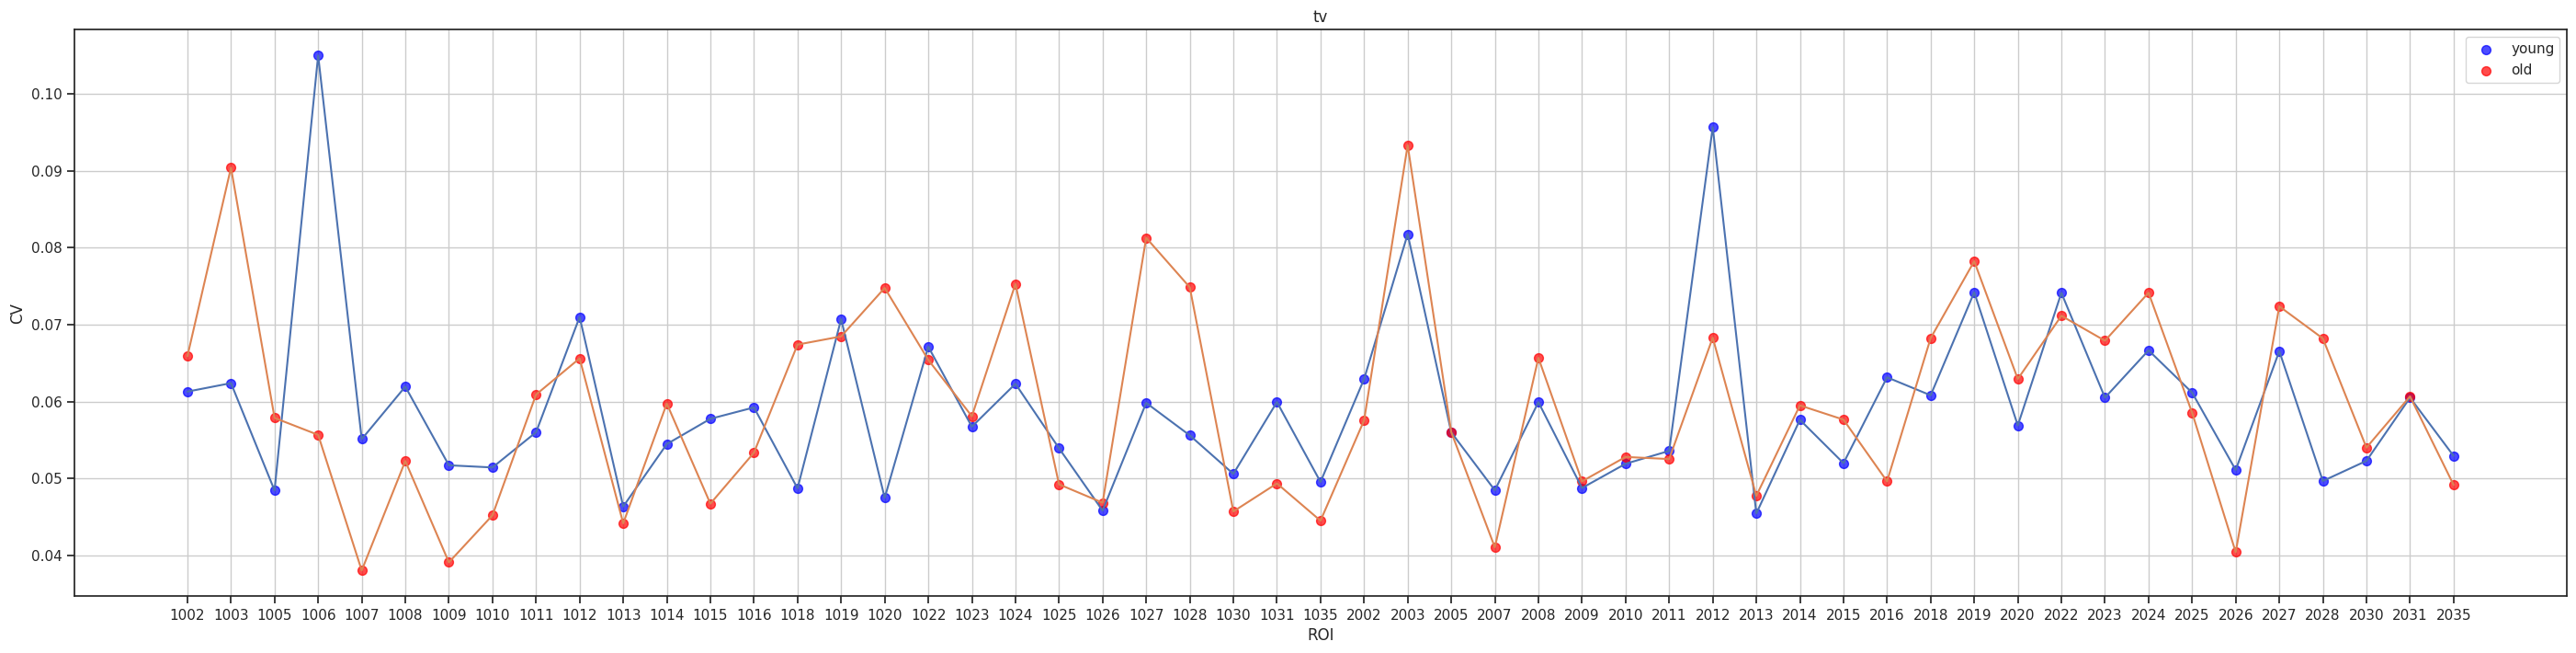

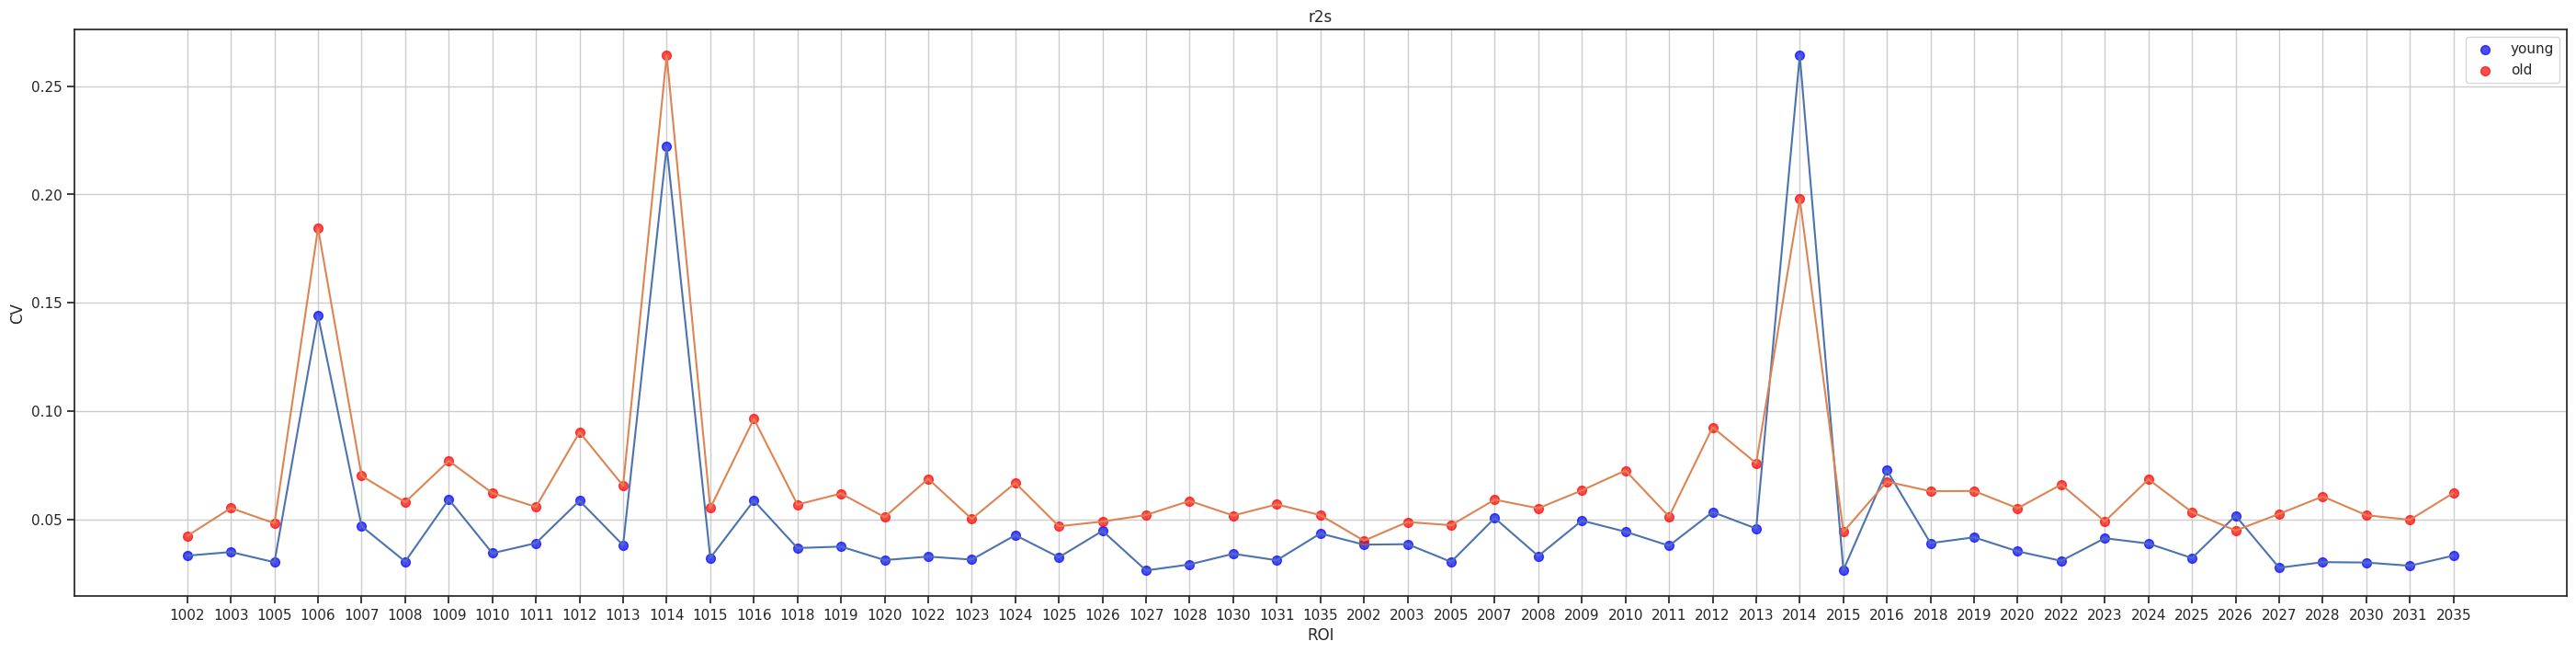

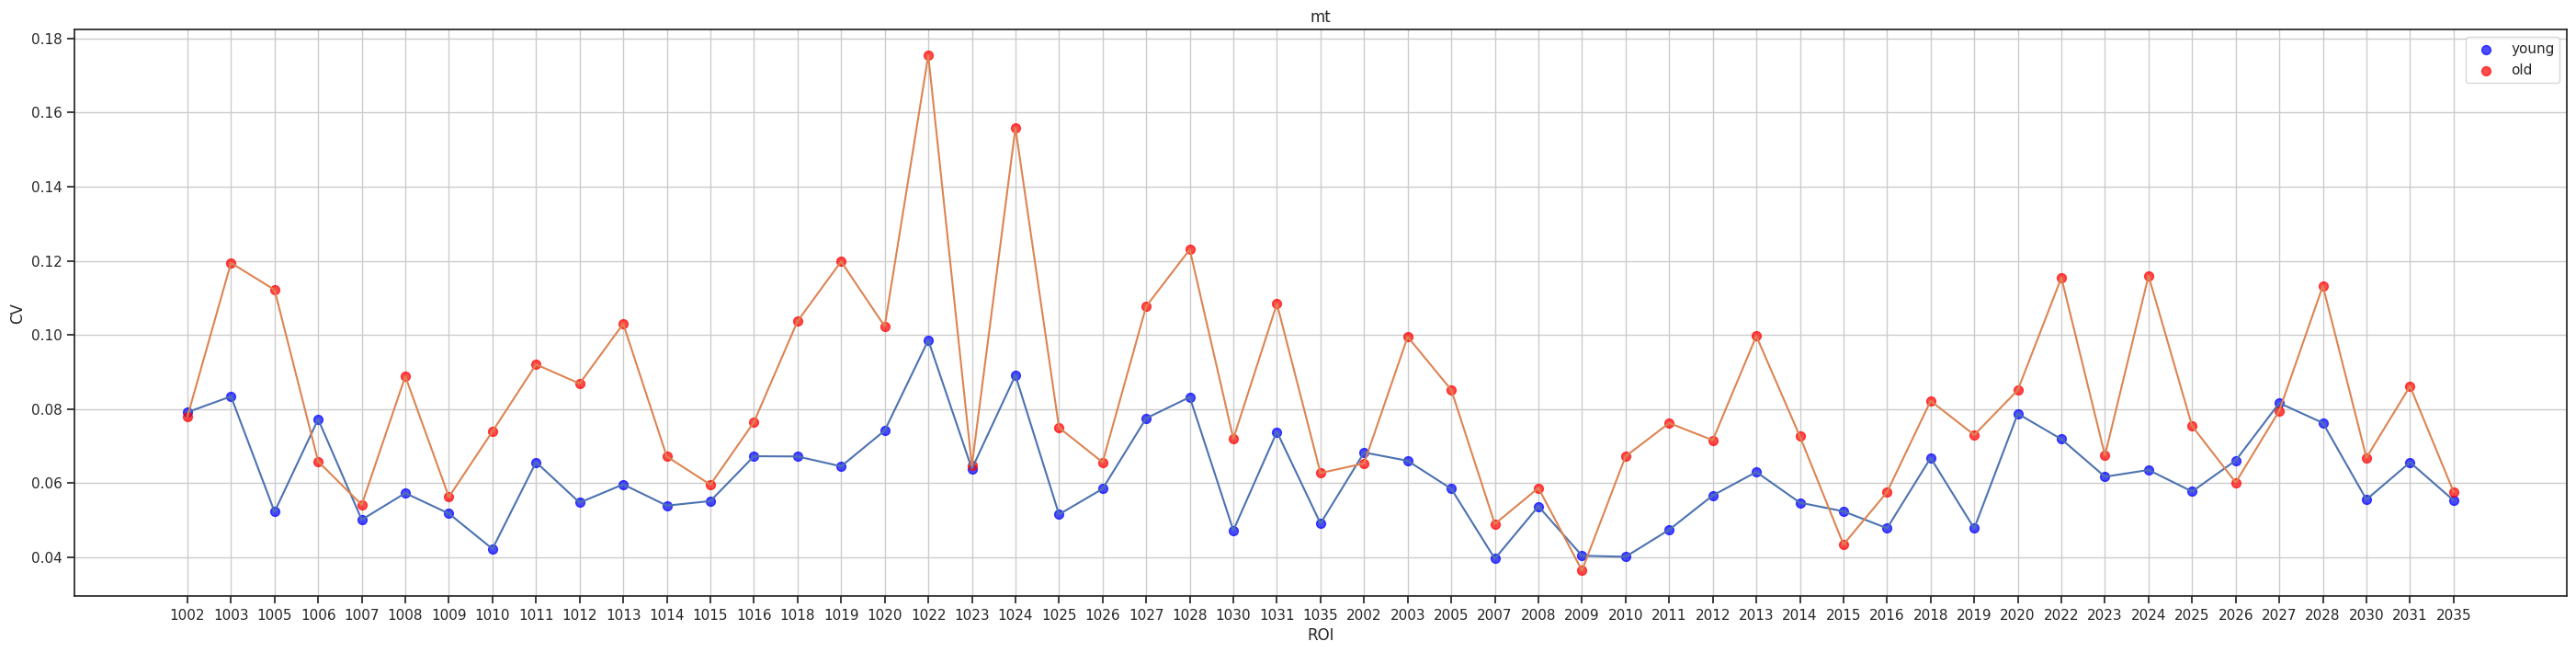

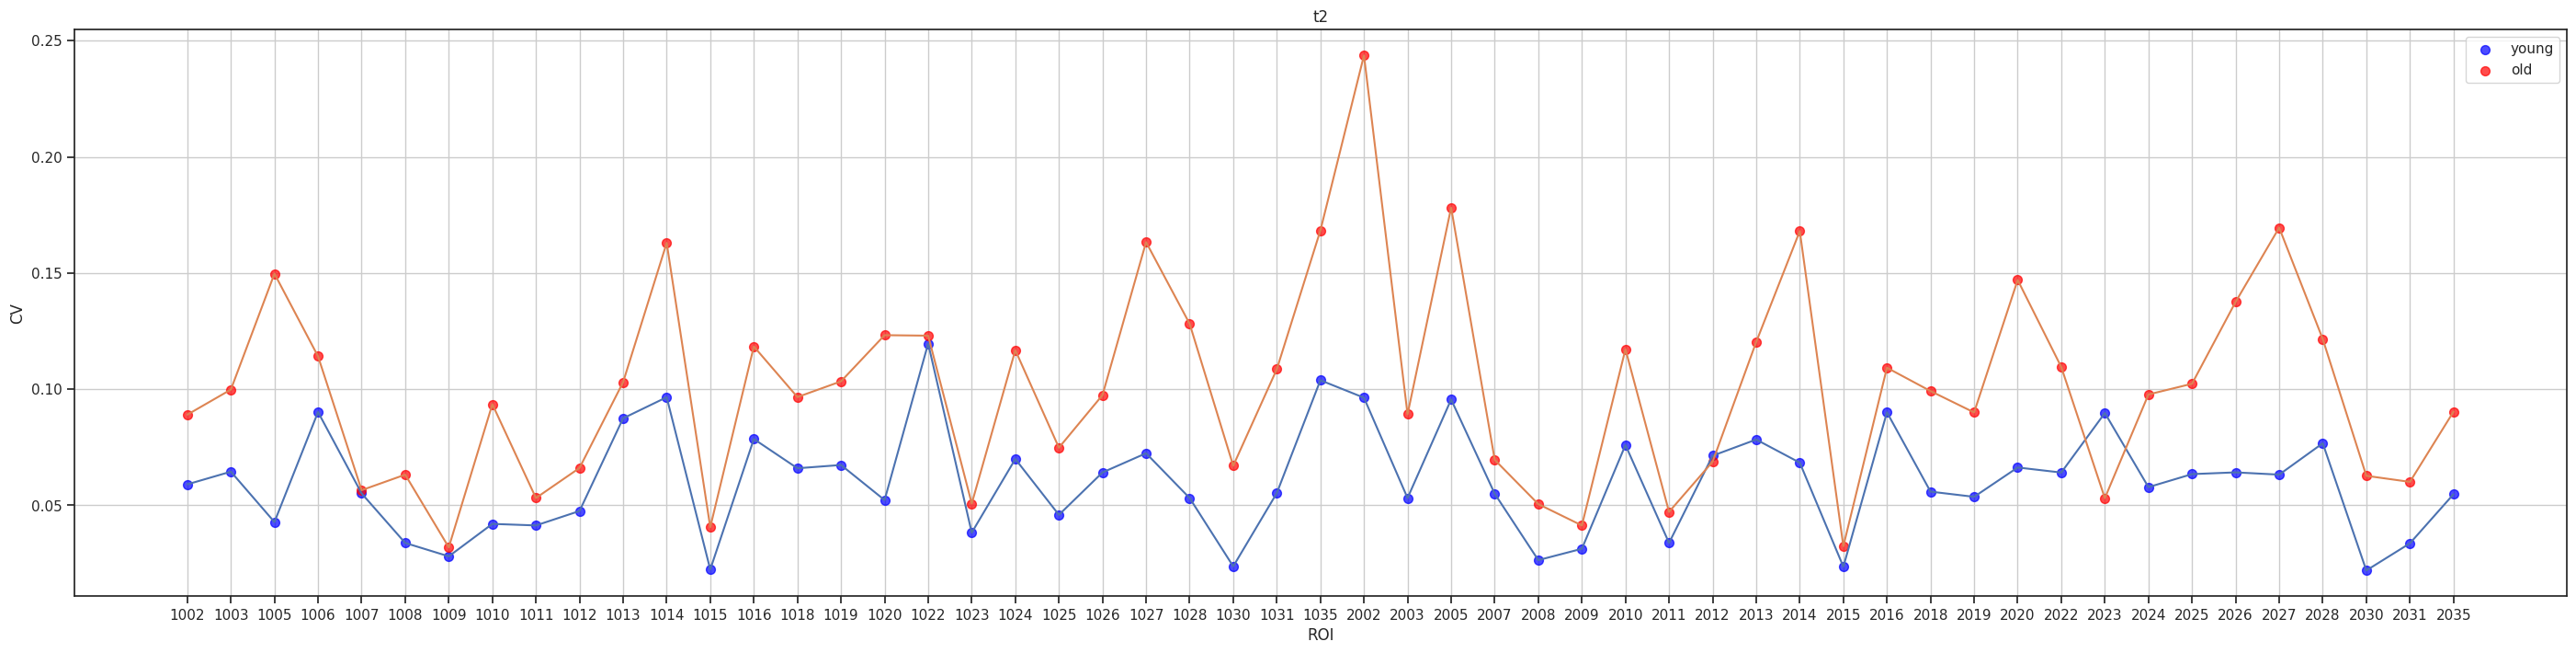

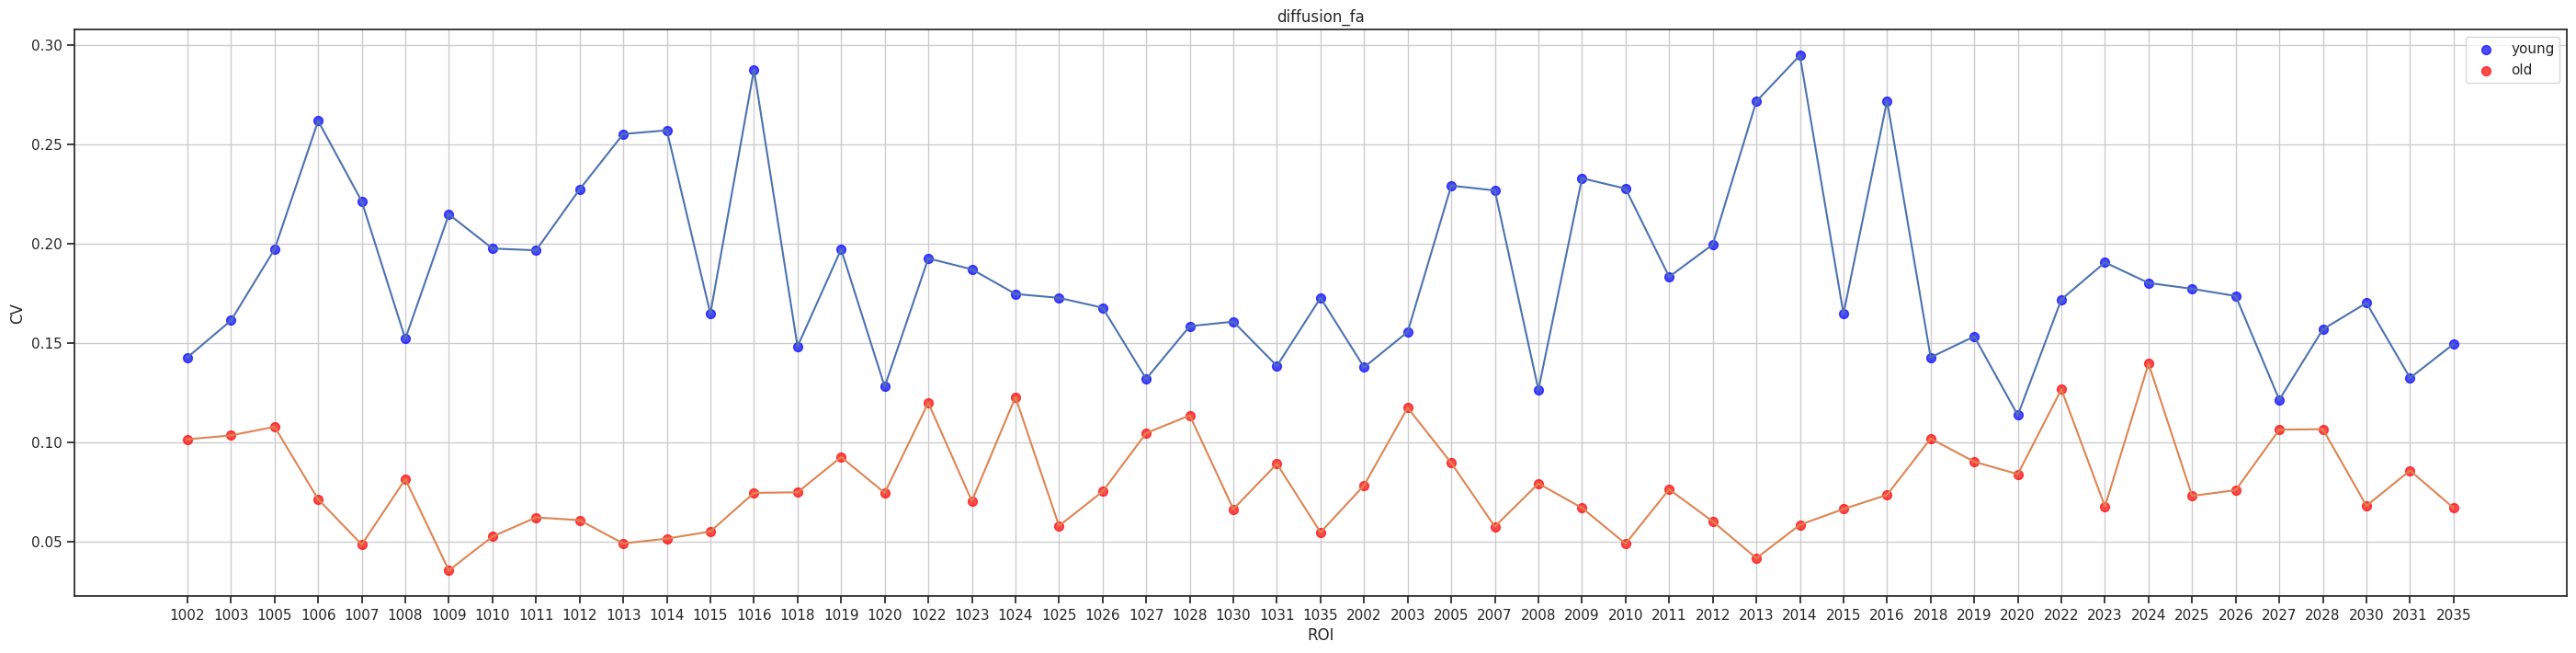

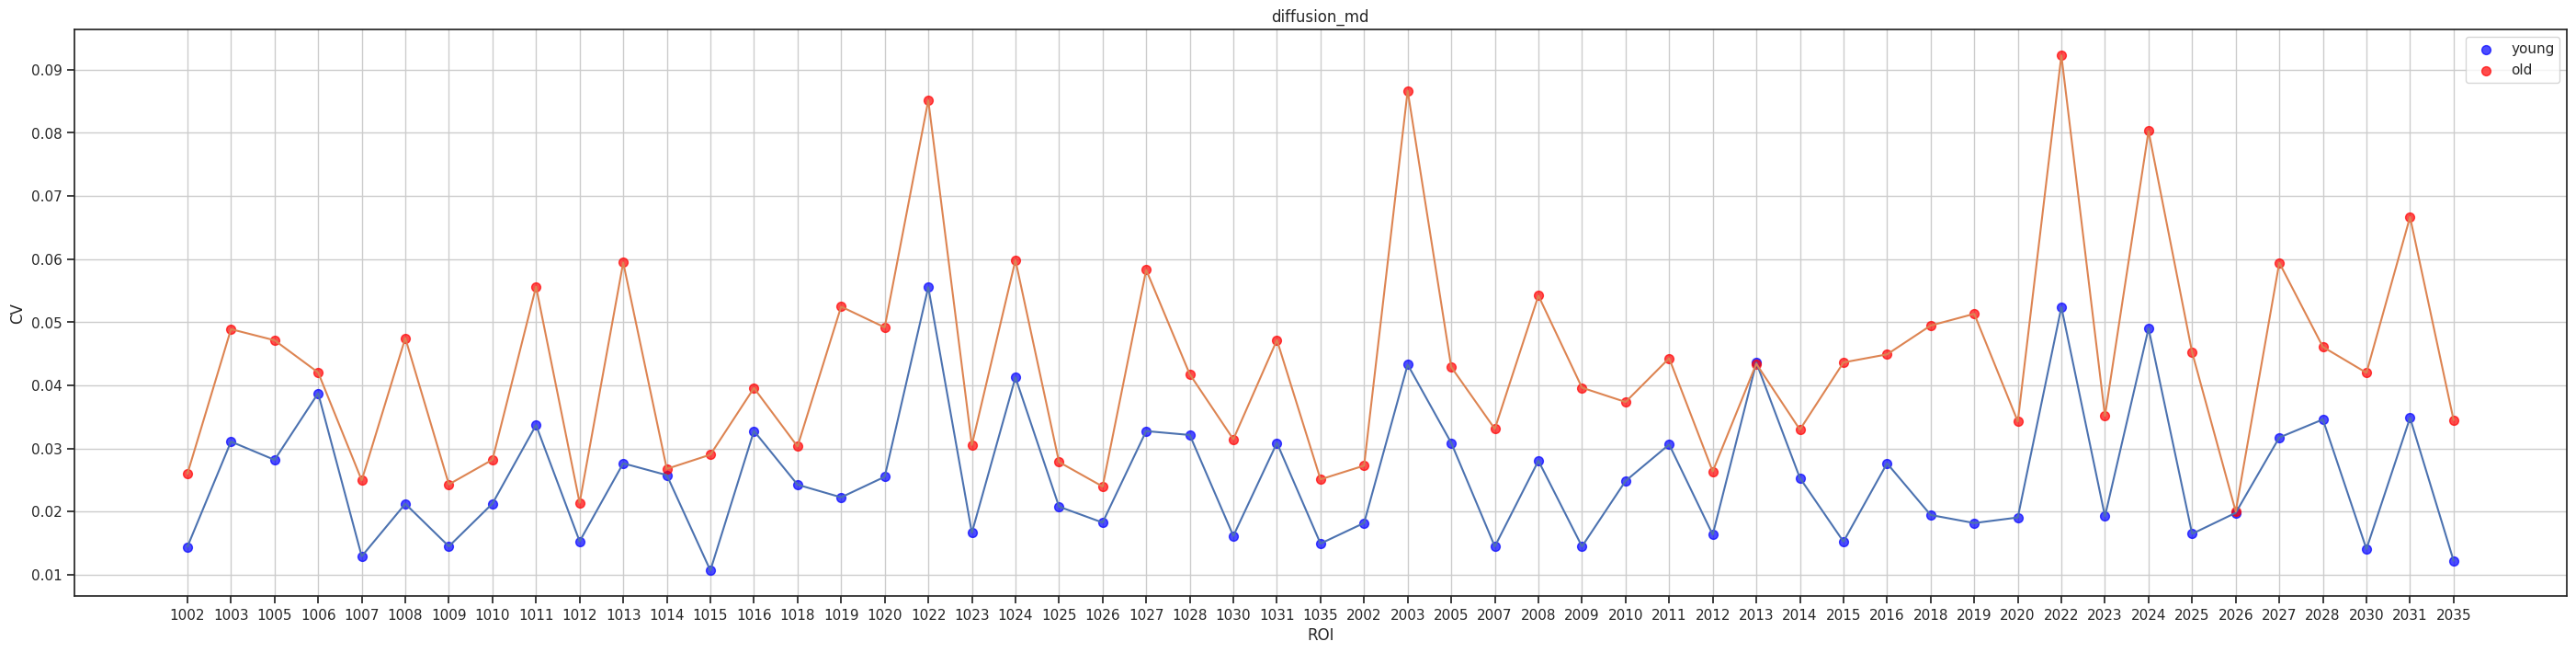

In [118]:
group_by_param = 'ROI'
x_axis = 'ROI'
data_groups = [(young_subjects, 'blue', 'young'), (old_subjects, 'red', 'old')]
calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(35, 8), connect_scatter=True)

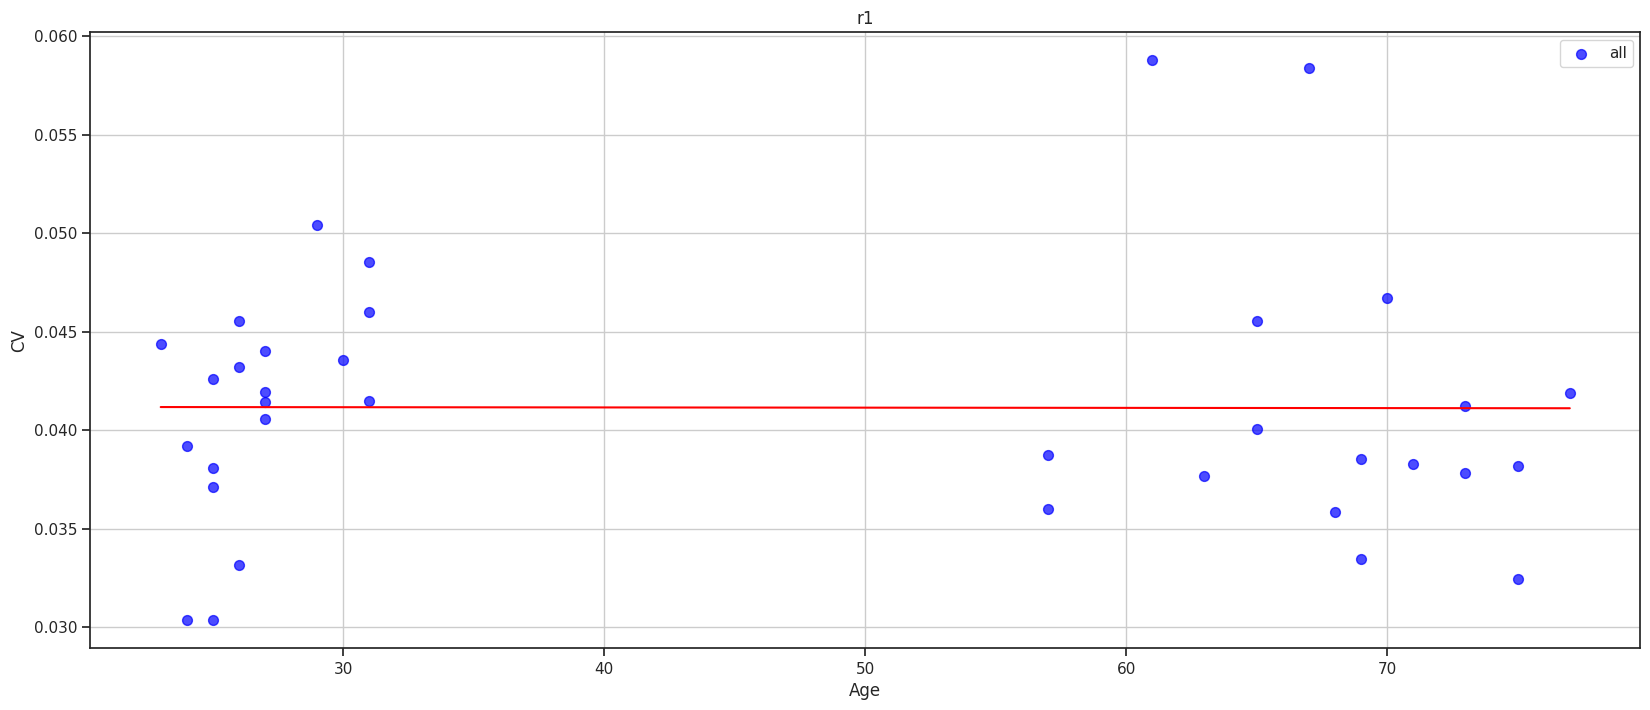

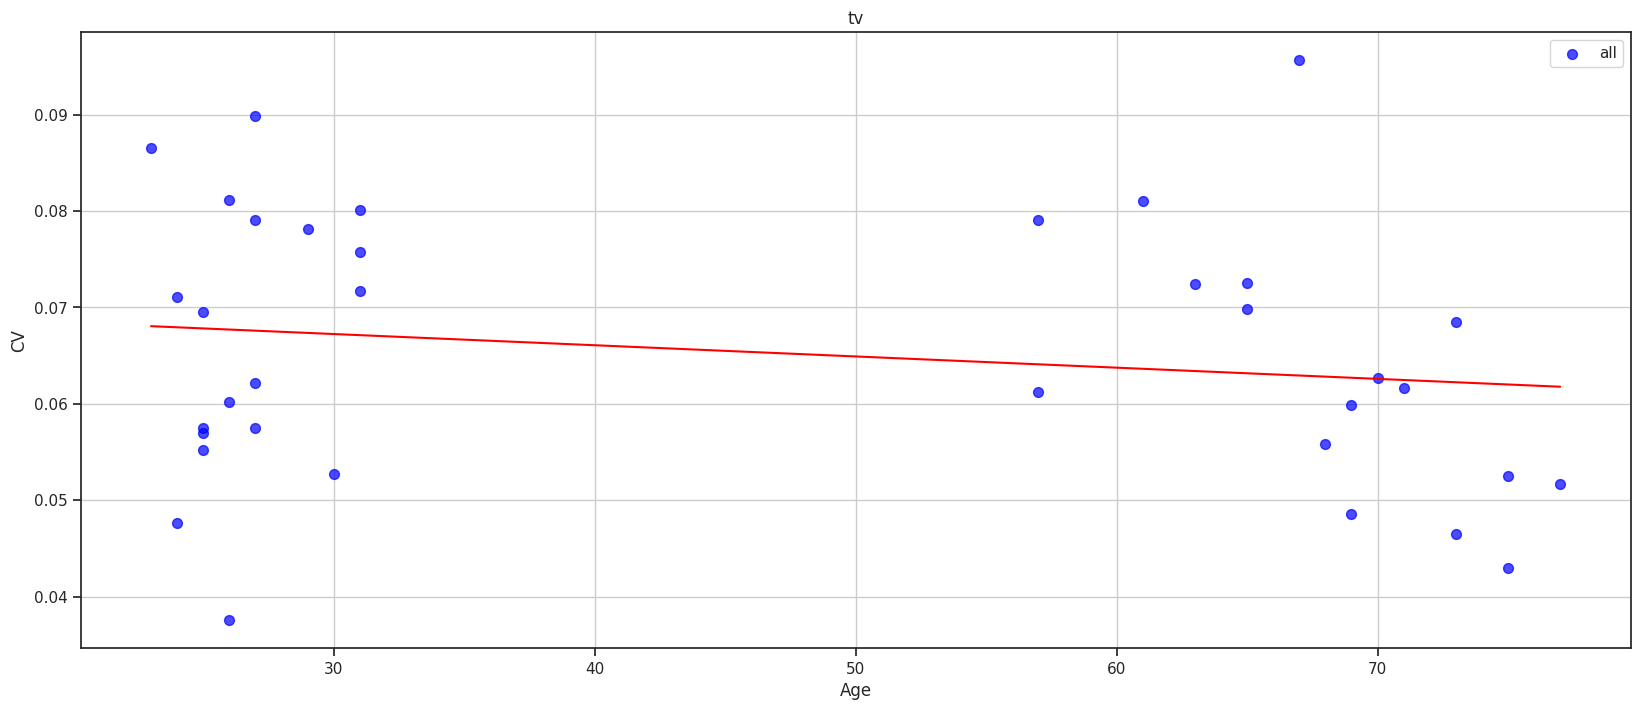

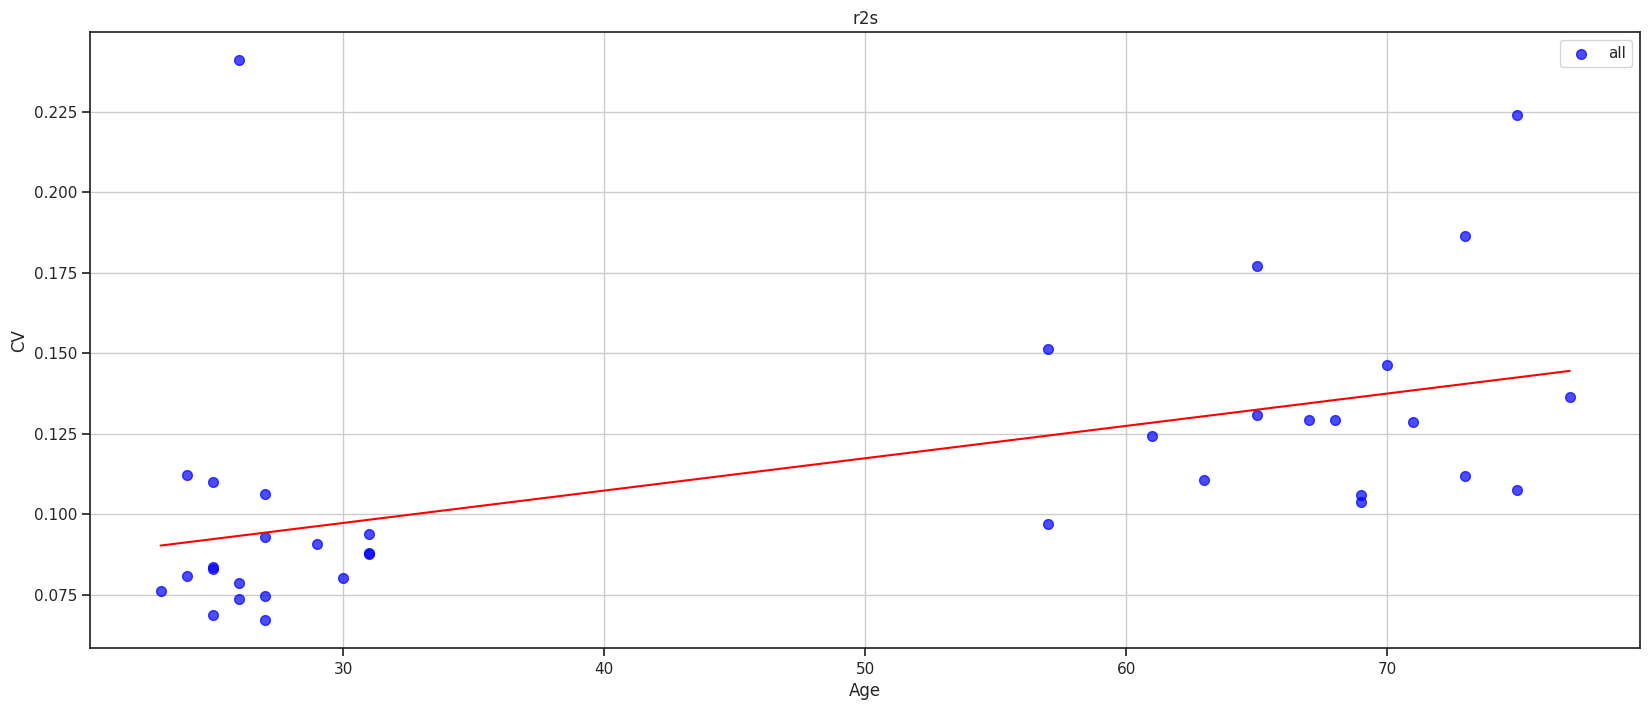

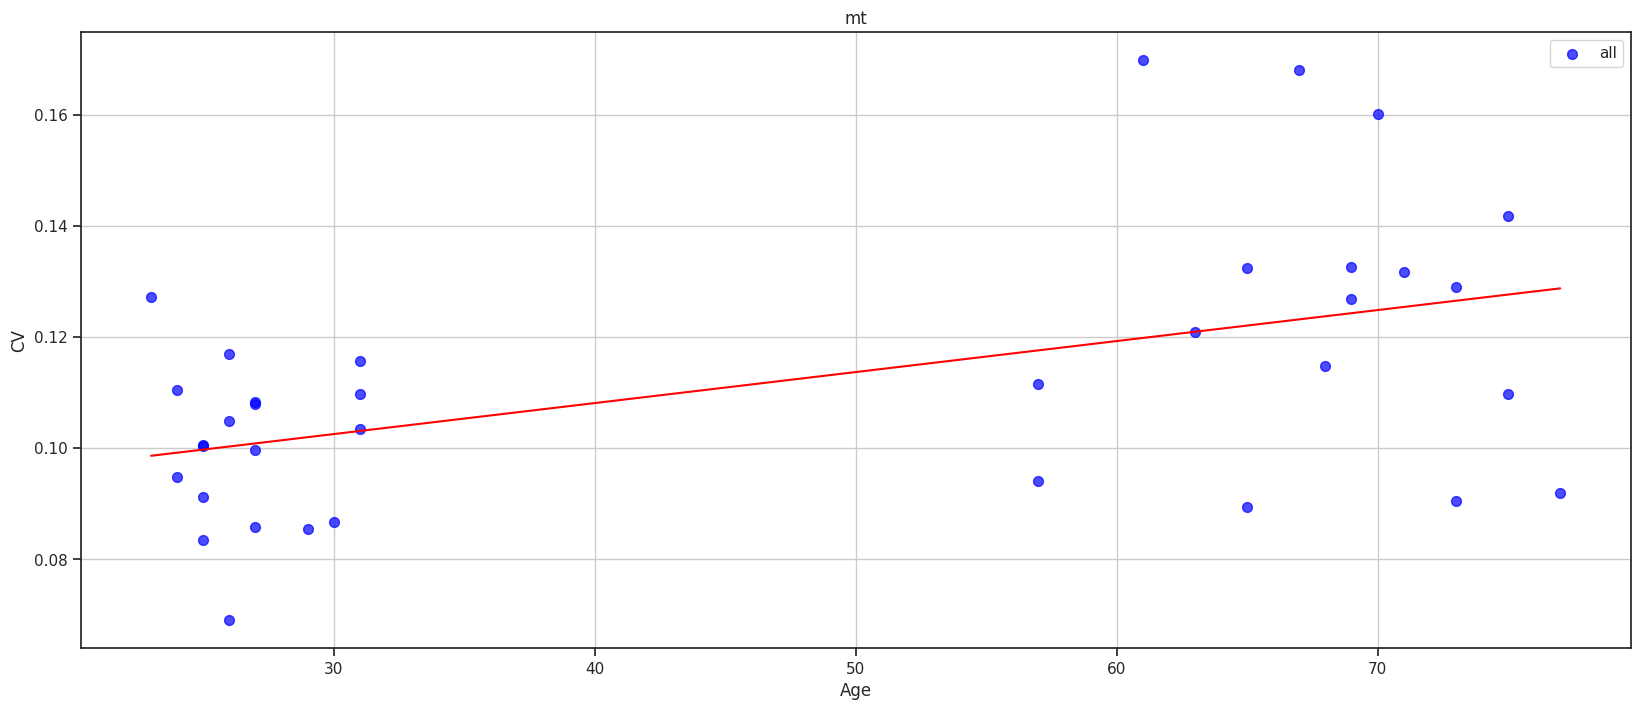

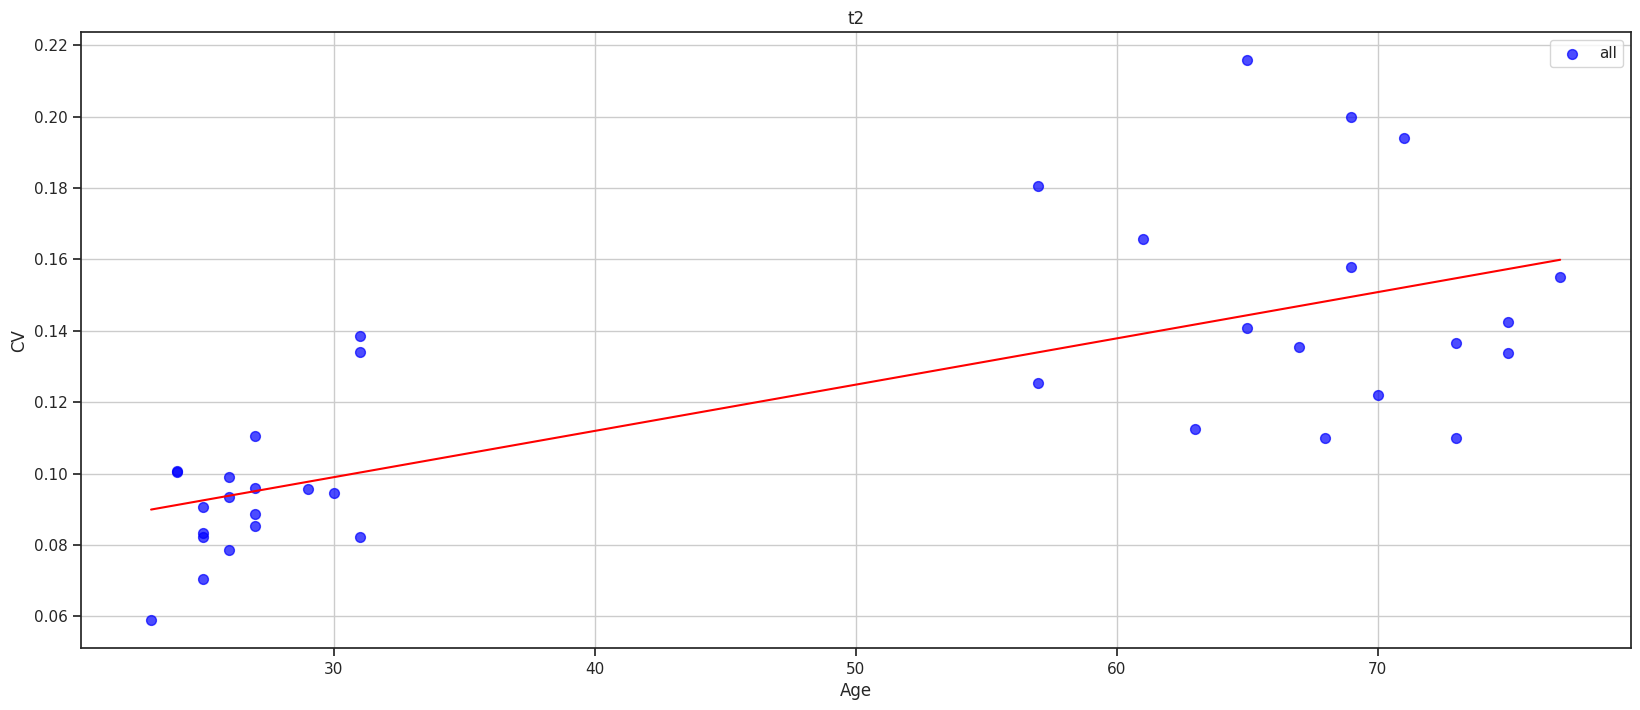

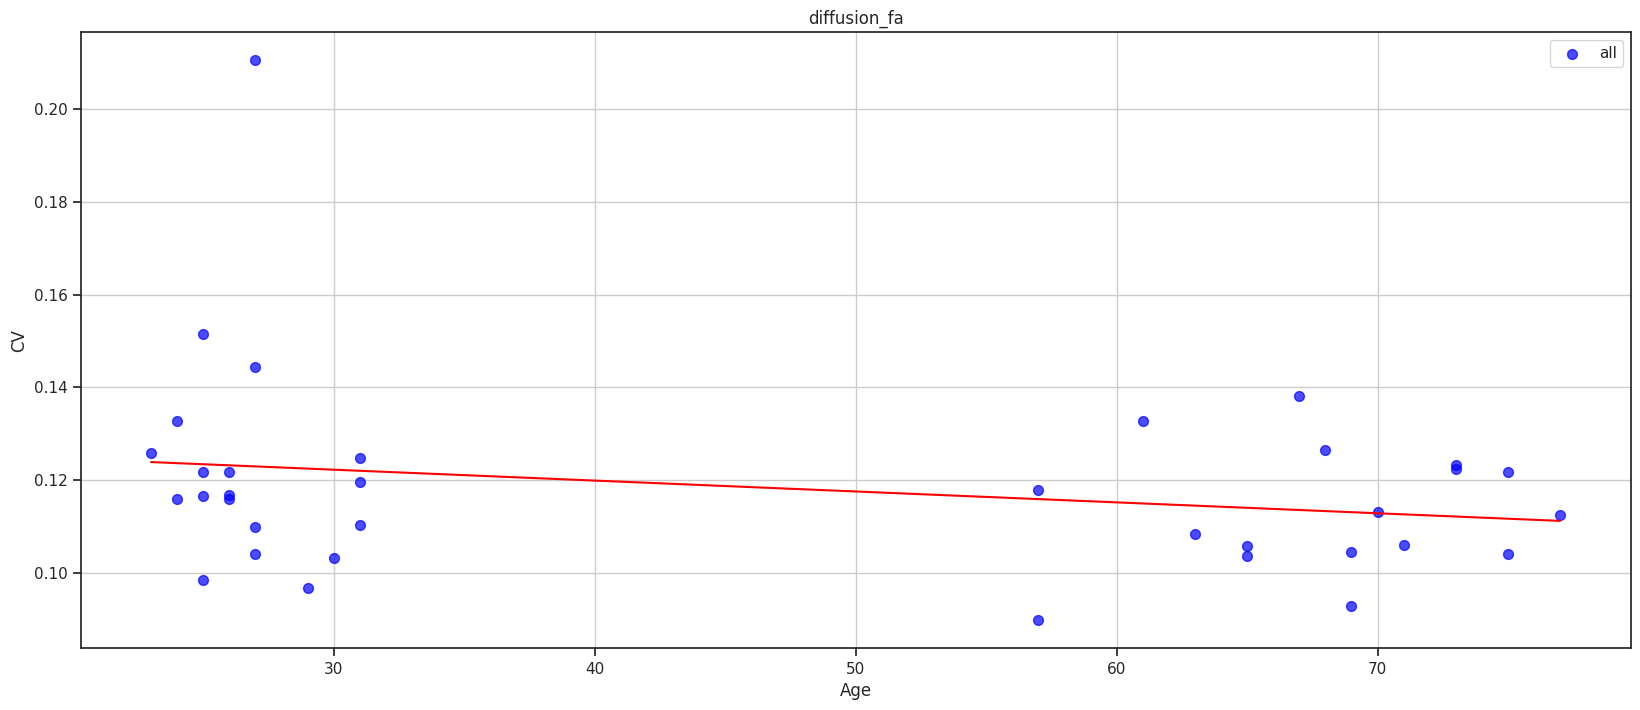

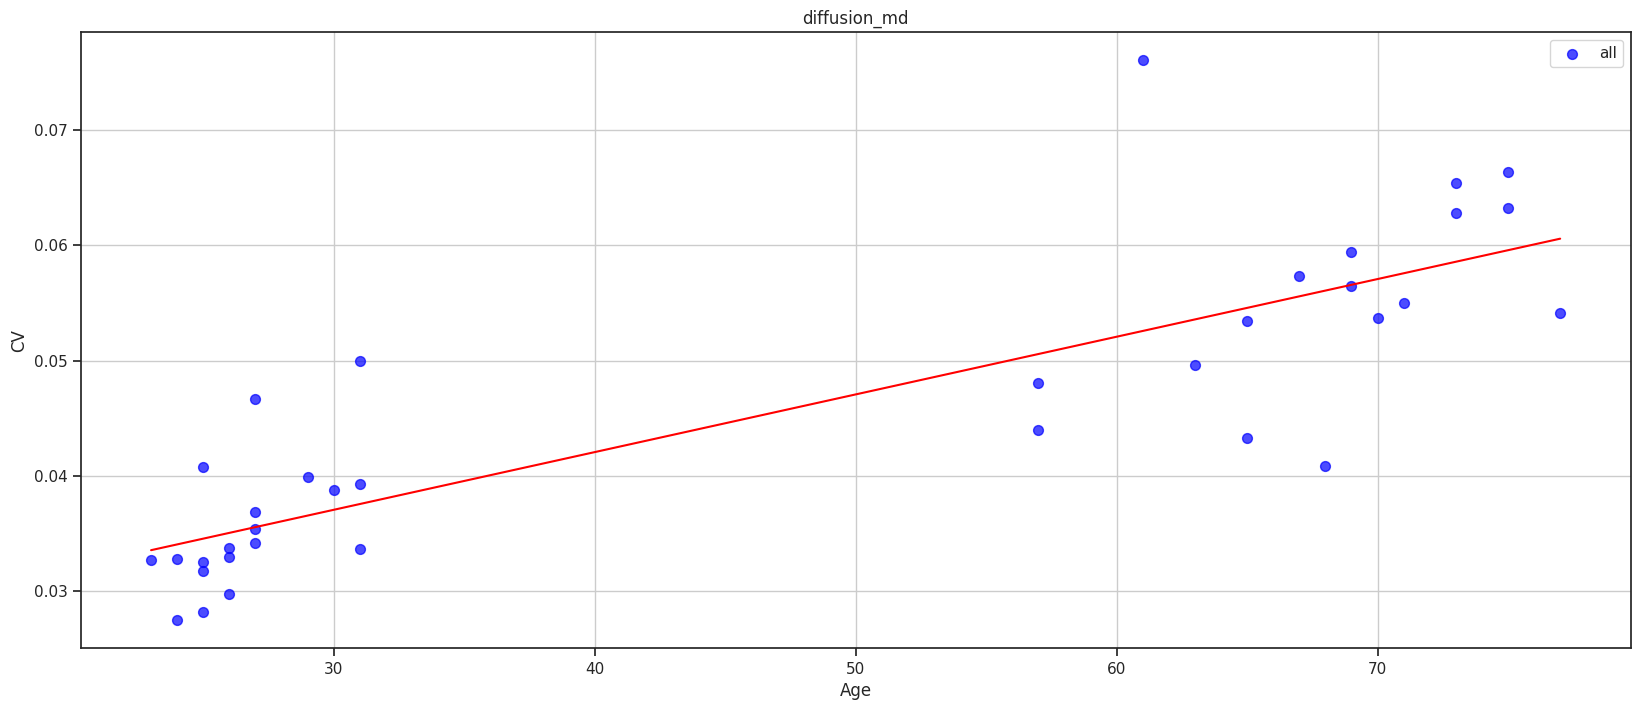

In [119]:
group_by_param = 'subjects'
x_axis = 'Age'
data_groups = [(chosen_data, 'blue', 'all')]
calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=True)

In [ ]:
# Get the test subject
test_subject = subjects_raw_data.subjects.unique()[0]
x_axis = []
y_axis = []

# Filter the data for the test subject
test_subject_df = subjects_raw_data[subjects_raw_data['subjects'] == test_subject]
    
# Iterate over ROIs and print the lengths of the arrays
for roi in test_subject_df.ROI.unique():
    values = test_subject_df[test_subject_df.ROI == roi].iloc[0]['r1']
    x_axis.append(f'{roi}')
    y_axis.append(len(values))

plt.figure(figsize=(30, 20))  # Adjust figure size as needed
plt.scatter(x_axis, y_axis, color='red', s=50, alpha=0.7)
plt.xlabel('ROI')
plt.ylabel('num voxels')
plt.title(f'{param}')
plt.grid(True)

In [5]:
from scipy.spatial.distance import pdist, squareform


def create_affinity_matrix(data, params, group_name, metric='euclidean'):
    subjects = data.groupby('subjects')
    relevant_rois = list(data.ROI_name.unique())
    distances = np.zeros((len(relevant_rois),
                            len(relevant_rois)))

    for subject_name, subject_df in subjects:
        df = subject_df[params]
        dist = pdist(df, metric=metric)
        distance_matrix = pd.DataFrame(squareform(dist), index=relevant_rois, columns=relevant_rois)
        distances += distance_matrix.to_numpy()

    distances /= data.subjects.nunique()

    PlotsManager.plot_heatmap(distances, f'{group_name} affinity matrix', None)

    return distances

In [ ]:
clusters_rois = StatisticsWrapper.hierarchical_clustering(chosen_data, params_to_work_with, 'single',
                                                            title="all")['dendrogram_data']['ivl']
young_result = StatisticsWrapper.roi_correlations(young_subjects, params_to_work_with, clusters_rois,
                                                    'young', method='spearman')
old_result = StatisticsWrapper.roi_correlations(old_subjects, params_to_work_with, clusters_rois, 'old', method='spearman')

# PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)

In [ ]:
young_result = create_affinity_matrix(young_subjects, params_to_work_with, 'young', 'cosine')
old_result = create_affinity_matrix(old_subjects, params_to_work_with, 'old', 'cosine')

In [8]:
young_result['corr_mean'] = young_result.apply(np.mean, axis=1) - 1/young_result.shape[0]
old_result['corr_mean'] = old_result.apply(np.mean, axis=1) - 1/old_result.shape[0]

# # young_mean = np.mean(young_result, axis=1)
# # old_mean = np.mean(old_result, axis=1)

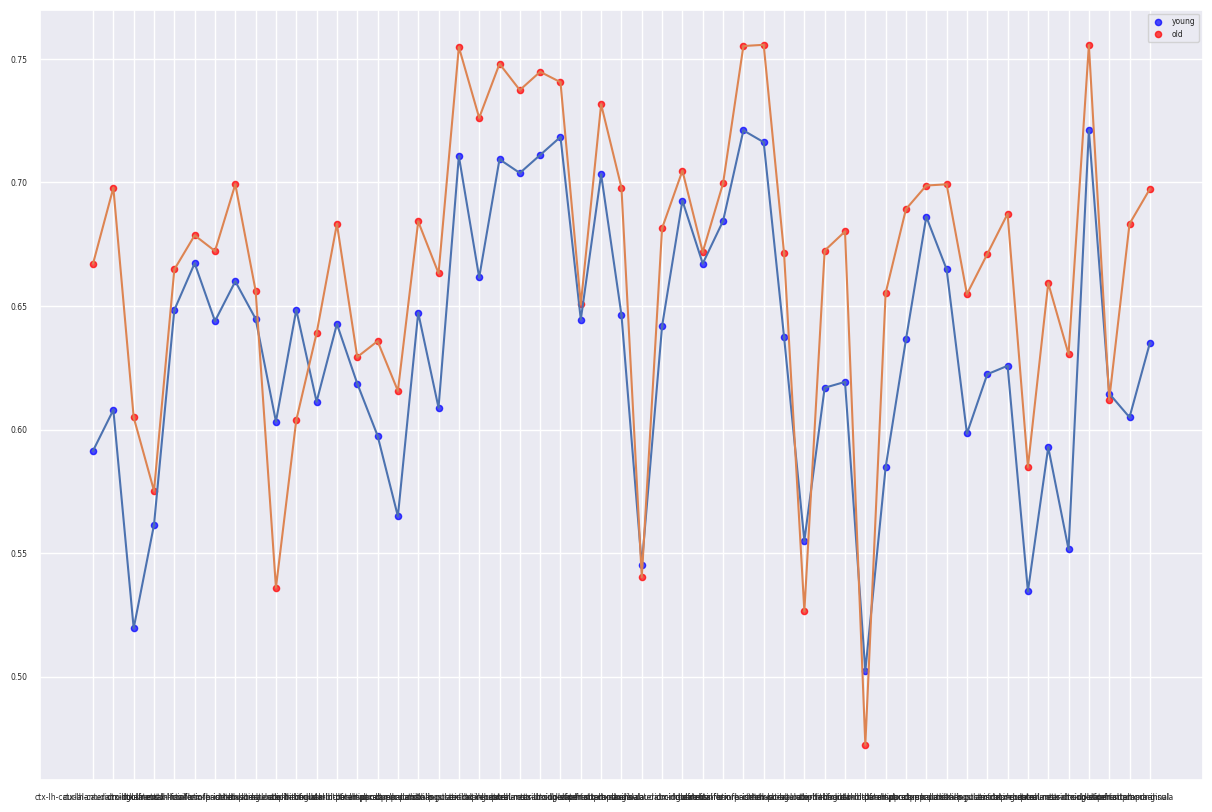

In [10]:
plt.figure(figsize=(15, 10))  # Adjust figure size as needed
plt.scatter(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
plt.scatter(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
plt.plot(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy())
plt.plot(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy())
plt.legend()
plt.grid(True)

In [ ]:
young_affinties = create_affinity_matrix(young_subjects, params_to_work_with, 'young', 'cosine')
old_affinties = create_affinity_matrix(old_subjects, params_to_work_with, 'old', 'cosine')
PlotsManager.plot_heatmap(old_affinties - young_affinties, 'dif', None)